In [4]:
import sys
print(sys.version_info)
from io import BytesIO

import math
from sqlalchemy import create_engine
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFE

print(matplotlib.__version__)

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

sys.version_info(major=3, minor=7, micro=6, releaselevel='final', serial=0)
3.1.3


In [5]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
pergrid_base = """select distinct * from predictor.pergrid_base"""
pergrid_base_df = pd.read_sql(pergrid_base, engine)

In [6]:
# separate predictor variables from outcome varaible
y = pergrid_base_df['tsr']
grid_id = pergrid_base_df['grid_id']
pred_var= ['aet', 'ai', 'art', 'ewd', 'fa', 'map', 'mat', 'mpdq',
       'mtcq', 'pet', 'psn', 'ra', 'rmap', 'rmat', 'tsn', 'mfdf', 'alt','shg','mtwq','wa']
pergrid_base_pred_df = pergrid_base_df[pred_var]

In [15]:
# pergrid_base_encoded=pd.get_dummies(pergrid_base_df_na_remove, columns=["hydrogroup"])
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder()
pergrid_base_df_na_remove.loc[: ,'shg'] = number.fit_transform(pergrid_base_df_na_remove['shg'])

In [8]:
from sklearn.impute import KNNImputer

# fill NaN with values from neighbor pixels
imputer = KNNImputer(n_neighbors=5)
pergrid_base_filled = imputer.fit_transform(pergrid_base_pred_df)
pergrid_base_df = pd.DataFrame(pergrid_base_filled)
pergrid_base_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,6000.0,0.36750,21.191667,-2.523666e+06,7.7058,681.0,20.036236,87.0,16.299375,1826.768199,50.411522,16.0,2.833333,0.604166,444.860212,2.270,11.597701,5.8,28.792500,4.1166
1,65535.0,0.38290,20.233612,-2.537902e+06,14.1498,699.0,20.298634,92.0,16.340292,1811.927757,49.797996,14.0,2.000000,0.620833,444.259982,2.100,5.982890,5.0,28.717458,11.8152
2,65535.0,1.30362,0.164286,-5.247088e+02,0.0711,1148.5,0.309987,131.5,21.304167,1918.111111,0.713689,1.0,1.833333,0.241667,3.698817,6.524,0.011696,2.0,28.626191,302.9049
3,5135.0,0.28980,23.950167,-2.941595e+06,3.0042,565.0,20.193576,76.0,15.517042,1972.128352,43.001180,108.0,2.333333,0.391667,492.281141,2.120,61.886973,5.4,29.458834,1.2528
4,5645.0,0.30170,23.526261,-2.959517e+06,10.0350,580.0,20.710174,80.0,15.754000,1928.968811,44.328019,34.0,3.416667,0.620833,489.587254,2.120,32.270955,5.0,29.300416,4.2480


In [9]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()
X_std = ss.fit_transform(pergrid_base_df)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=pergrid_base_pred_df.index,
                columns=pred_var)

In [25]:
len(pred_var)

19

In [26]:
X = pergrid_base_df_na_remove[pred_var]
# standarize predictors
ss = StandardScaler(with_mean=True, with_std=True)
X_std = ss.fit_transform(X.values)

Xstd=pd.DataFrame(data=X_std[0:,0:],
                index=X.index,
                columns=pred_var)
y = pergrid_base_df_na_remove['tsr']

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(Xstd, y, test_size=0.2, random_state=12345)

In [13]:
from sklearn.svm import SVR

# Create the RFE object and compute a cross-validated score.
svr = SVR(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svr, step=1, cv=StratifiedKFold(10))

In [14]:
rfecv.fit(x_train, y_train)

/Users/lianfeng/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                    gamma='scale', kernel='linear', max_iter=-1, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [15]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 20


In [47]:
from sklearn.linear_model import Lasso
lasso00001 = Lasso(alpha=0.0001, max_iter=10e5)
rfecv = RFECV(estimator=lasso00001, step=1, cv=StratifiedKFold(10))

In [16]:
rfecv.fit(x_train, y_train)

/Users/lianfeng/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                    gamma='scale', kernel='linear', max_iter=-1, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

In [17]:
print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 20


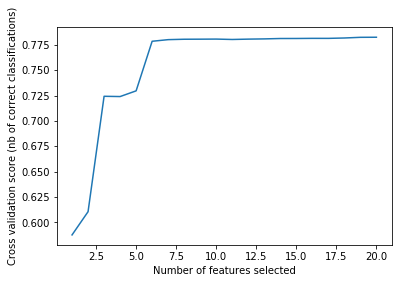

In [18]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [21]:
rfecv.grid_scores_

array([0.49492476, 0.71007896, 0.79444918, 0.83821461, 0.8482023 ,
       0.8496809 , 0.8527981 , 0.85173506, 0.85201368, 0.85381143,
       0.85500854, 0.8551457 , 0.85804325, 0.85775083, 0.85873696,
       0.85958543, 0.8598328 , 0.86086291, 0.8615107 , 0.86195091])

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 42, bootstrap=True)
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(10))
rfecv.fit(Xstd, y)
print("Optimal number of features : %d" % rfecv.n_features_)

/Users/lianfeng/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Optimal number of features : 20


In [23]:
len(rfecv.grid_scores_)

20

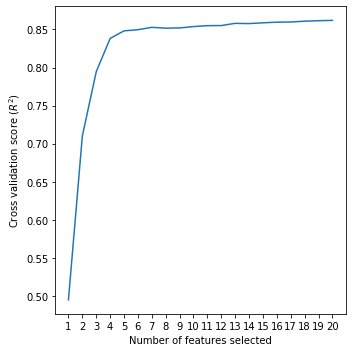

In [32]:
# Plot number of features VS. cross-validation scores
from pylab import rcParams
rcParams['figure.figsize'] = 5, 5
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score ($R^2$)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
yint = range(1, math.ceil(20)+1)
plt.xticks(yint)
plt.tight_layout()
plt.show()

In [27]:
from sqlalchemy import create_engine
import sys
import pandas as pd
import matplotlib.pyplot as plt

In [33]:
localhost = {'user': 'postgres', 'password': 'postgres', 'host': 'localhost', 'port': 5432, 'db': 'fiadb'}
params = 'postgresql://{0}:{1}@{2}:{3}/{4}'
engine = create_engine(params.format(localhost['user'], localhost['password'], localhost['host'], localhost['port'], localhost['db']))
# geom_sql = """select distinct grid_id, grid_geom from fs_fiadb.pergrid"""
lasso_y_test = """select * from predictor.lasso_y_test"""
lasso_y_test_pd = pd.read_sql(lasso_y_test, engine)

rf_y_test = """select * from predictor.rf_y_test"""
rf_y_test_pd = pd.read_sql(rf_y_test, engine)

lasso_y_test_pd = lasso_y_test_pd.sample(n=int(lasso_y_test_pd.shape[0]/2), random_state=1234)
rf_y_test_pd = rf_y_test_pd.sample(n=int(rf_y_test_pd.shape[0]/2), random_state=1234)

Text(0.5, 1.0, '(c) Random Forest-based RFE')

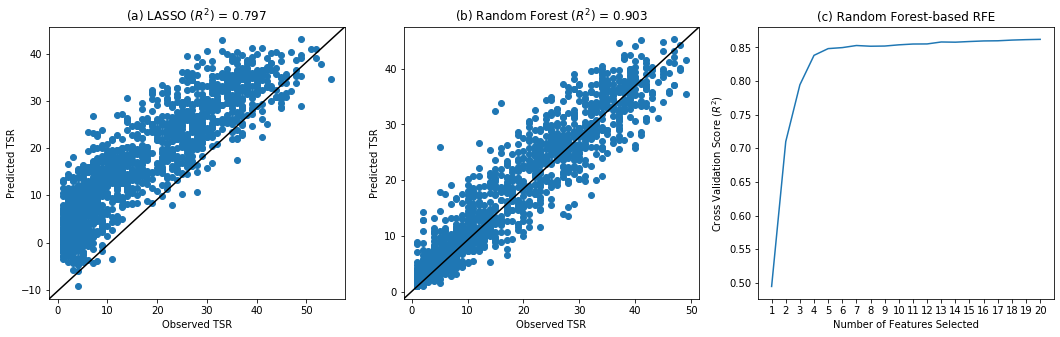

In [50]:
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.lines as mlines

rcParams['figure.figsize'] = 18, 5

fig, (ax1, ax2, ax3) = plt.subplots(1,3)

ax1.scatter(lasso_y_test_pd['tsr'], lasso_y_test_pd['tsr_predicted'])
ax1.set_title('(a) LASSO ($R^2$) = 0.797')
ax1.set_xlabel('Observed TSR')
ax1.set_ylabel('Predicted TSR')
ax1.grid(False)
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax1.transAxes
line.set_transform(transform)
ax1.add_line(line)

ax2.scatter(rf_y_test_pd['tsr'], rf_y_test_pd['tsr_predicted'])
ax2.set_title('(b) Random Forest ($R^2$) = 0.903')
ax2.set_xlabel('Observed TSR')
ax2.set_ylabel('Predicted TSR')
ax2.grid(False)
line = mlines.Line2D([0, 1], [0, 1], color='black')
transform = ax2.transAxes
line.set_transform(transform)
ax2.add_line(line)

ax3.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
yint = range(1, math.ceil(20)+1)
ax3.set_xticks(yint)
ax3.set_xlabel("Number of Features Selected")
ax3.set_ylabel("Cross Validation Score ($R^2$)")
ax3.set_title('(c) Random Forest-based RFE')